In [31]:
import pandas as pd
import numpy as np
import os

from train.metrics_f1 import calc_f1_score

### Воспроизведение лучшего скора

In [32]:
df_train_raw = pd.read_csv('train/data/train.csv')
df_test_raw = pd.read_csv('train/data/test.csv')
df_train_raw.sample(5)

,wagnum,month,target_month,target_day,10d_nasip_mean,5d_avg_distance_min,10d_isload_mean,60d_opor_station_sign_mean,60d_skoroport_mean,60d_avg_distance_max,...,months_after_pr_rems,is_in_kti,ost_prob_in_3_months,ost_prob_in_10_days,age_y,days_since_kap,days_since_dep,30d_next_time_prob,5d_next_time_prob,season
31762,31762,2022-09-01,0,0,1.0,1663.751516,0.4,0.0,0.0,2540.472727,...,731.0,0,118965.0,143330.333333,12.523288,95.0,1091.0,142896.200000,144443.622907,autumn
95105,27153,2022-11-01,1,1,0.8,1994.932623,0.4,0.7,0.0,3128.434783,...,733.0,0,-20488.0,1674.666667,13.528767,693.0,1357.0,1316.565217,1316.565217,autumn
155532,19608,2023-01-01,0,0,0.0,141.250000,0.0,0.0,0.0,2916.882353,...,735.0,1,15506.0,29919.333333,26.520548,4213.0,954.0,28804.117647,29724.744949,winter
169784,33859,2023-01-01,0,0,1.0,1922.963702,1.0,0.0,0.0,2415.462500,...,735.0,0,-3613.0,14600.333333,3.854795,NaN,NaN,14561.167028,14954.036298,winter
13276,13276,2022-09-01,0,0,0.3,1044.355556,0.1,0.0,0.0,2540.472727,...,731.0,0,77428.0,84513.333333,13.191781,442.0,1220.0,83156.772277,83435.904497,autumn


In [33]:
targets = ['target_month', 'target_day']
categorical = ['kod_vrab', 'model',  'zavod_build', 'kuzov', 'telega', 'expected_srok_sl_y_b', 'date_build_b', 'manage_type', 'rod_id_x', 'reestr_state',
                'tormoz', 'tipvozd', 'tippogl', 'ownertype', 'iskl_in_a_year', 'season', 'is_in_kti']
dates = ['month', 'date_kap', 'date_dep', 'date_pl_rem', 'last_rem_date', 'date_build', 'srok_sl']
for date in dates:
    df_train_raw[date] = pd.to_datetime(df_train_raw[date])
    df_test_raw[date] = pd.to_datetime(df_test_raw[date])

# Данные фичи были выбраны с помощью recursive feature elimination, цель была оставить ровно 20 штук

features_day = ['30d_next_time_prob', 'days_to_pl_rem', 'ost_prob_in_a_month', 'last_month_for_cnt', 'ost_prob_in_10_days',
                 '_allm_pr_rems', 'days_since_dep', '5d_st_freigh_sign_mean', 'days_from_last_rem', '5d_avg_distance_min',
                   'ost_prob', '10d_nasip_mean', '5d_st_river_sign_mean', '5d_next_time_prob',
                 '5d_diff_mean', '5d_nasip_mean', '30d_st_sea_sign_mean', '10d_st_sea_sign_mean',
                   '10d_st_freigh_sign_mean', '10d_st_car_sign_mean']

features_month = ['ost_prob_in_a_month', 'ost_prob_in_10_days', 'days_to_pl_rem', 'ost_prob', '30d_next_time_prob', '_allm_pr_rems',
                   '5d_st_sea_sign_mean', 'gruz', '5d_st_car_sign_mean', '5d_st_river_sign_mean', '5d_st_freigh_sign_mean', 'days_to_srok_sl',
                    'season', '10d_st_car_sign_mean', '10d_st_sea_sign_mean', 'model', 'cnsi_gruz_capacity',
                      '5d_opor_station_sign_mean', '10d_st_freigh_sign_mean', 'norma_km']

numerical = [col for col in df_train_raw.columns if col not in categorical + dates + targets]
medians = df_train_raw[features_day].median()

def preprocess(df):
  df[categorical] = df[categorical].astype('str')
  df[numerical] = df[numerical].fillna(medians)

  return df

df_train = preprocess(df_train_raw)
df_test = preprocess(df_test_raw)

In [34]:

from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
from catboost import Pool

month_to_predict = pd.to_datetime('2023-02-01')
train_ind = df_train_raw['month'] < month_to_predict
test_ind = df_train_raw['month'] == month_to_predict

def train(target, features):

    data = df_train[features]

    X_train = data[train_ind].drop(targets, axis=1)
    X_test = data[test_ind].drop(targets, axis=1)

    y_train = data[train_ind][target]
    y_test = data[test_ind][target]

    clf = CatBoostClassifier(
        iterations=1000,
        learning_rate=0.1,
        random_seed=42,
        eval_metric='F1',
        cat_features=list(set(categorical) & set(features)),
        early_stopping_rounds=200,
        verbose=False,
    )

    clf.fit(
        X_train, y_train,
        eval_set=(X_test, y_test),
        plot=True
    )

    y_pred = clf.predict(X_test)
    print(f"Score for {target}: {f1_score(y_test, y_pred)}")
    return clf


month_clf = train('target_month', features_month + targets)
day_clf = train('target_day', features_day + targets)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Score for target_month: 0.689745264532985


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Score for target_day: 0.5565610859728508


In [35]:
def predict(clf_day, clf_month, df):
    pred_day = clf_day.predict(df[features_day])
    pred_month = clf_month.predict(df[features_month])

    
    df_test_new = df_test_raw.copy()
    df_test_new['target_day'] = pred_day
    df_test_new['target_month'] = pred_month

    df_test_new = df_test_new[['wagnum', 'target_month', 'target_day']]
    sample = pd.read_csv('train/target/y_predict.csv')
    sample = sample.merge(df_test_new, on='wagnum', how='left')

    return sample

prediction = predict(day_clf, month_clf, df_test)
assert len(prediction) == len(df_test)

prediction.describe()

,wagnum,target_month,target_day
count,33707.000000,33707.000000,33707.000000
mean,17062.180437,0.047913,0.010858
std,9805.705493,0.213585,0.103637
min,0.000000,0.000000,0.000000
25%,8663.500000,0.000000,0.000000
50%,17115.000000,0.000000,0.000000
75%,25546.500000,0.000000,0.000000
max,33976.000000,1.000000,1.000000


In [36]:
# Проверяем что результат действительно совпадает

true_prediction = pd.read_csv('predictions/catboost-best.csv')
assert (true_prediction.target_month != prediction.target_month).sum() == 0
assert (true_prediction.target_day != prediction.target_day).sum() == 0

In [37]:
def plot_feature_importance(importance, names, model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data = pd.DataFrame({'feature_names': feature_names, 'feature_importance': feature_importance})
    data.sort_values(by=['feature_importance'], ascending=False, inplace=True)

    display(data.head(20))


plot_feature_importance(day_clf.get_feature_importance(), features_day, 'CATBOOST DAY ')
plot_feature_importance(month_clf.get_feature_importance(), features_month, 'CATBOOST MONTH ')

,feature_names,feature_importance
1,days_to_pl_rem,13.949749
10,ost_prob,11.371037
0,30d_next_time_prob,10.282621
5,_allm_pr_rems,6.527147
13,5d_next_time_prob,5.457471
8,days_from_last_rem,5.323634
14,5d_diff_mean,5.006222
3,last_month_for_cnt,4.789840
9,5d_avg_distance_min,4.068602
2,ost_prob_in_a_month,3.744120


,feature_names,feature_importance
1,ost_prob_in_10_days,20.596327
2,days_to_pl_rem,17.486866
4,30d_next_time_prob,16.413075
3,ost_prob,14.712425
5,_allm_pr_rems,12.150738
7,gruz,3.290661
0,ost_prob_in_a_month,3.130890
11,days_to_srok_sl,1.695658
6,5d_st_sea_sign_mean,1.421595
14,10d_st_sea_sign_mean,1.413973


In [38]:
prediction.to_csv('predictions/catboost.csv', index=False)

### Аналитика

В модели прдесказывающей на месяц вперед, в порядке убывания признаки наибольшей важности это:

- Количество дней до следующего планового ремонта (тут все логично)
- Остаточный пробег (тут тоже)
- Следующая фича - сконструированная - сколько пробега останется, если мы совершим поездку на расстояние равное средней дистанции поездки за последний месяц. То есть по сути мы смотрим на то, сможет ли вагон совершить еще одну поездку целиком или нет
- Следующая фича - количество предыдущих ремонтов вагона, ее влияние понятно
- Из интересного - на результат также влияют данные о перевозимом грузе. В частности признак погрузки насыпью. Это может быть связано с тем как разные грузы по разному влияют на износ вагона

Теперь посмотрим на десятидневную модель - здесь помимо вышеперечисленных признаков небольшую роль сыграла грузоподъемность вагона. Почему это так сходу не понятно, тут требуется дальнейшее исследование

Для более простой интерпретации моделей можно предложить использовать обычные решающие деревья. Например ниже представлено дерево, дающее весьма неплохой скор на предсказании на 10 дней и при этом очень просто интерпретирующееся: 1 возвращается при совпадении трех условий. При желании можно поподбирать параметры и получить деревья сопостовимые по качеству с бустингом, но при этом понятные человеку

0.4892367906066536

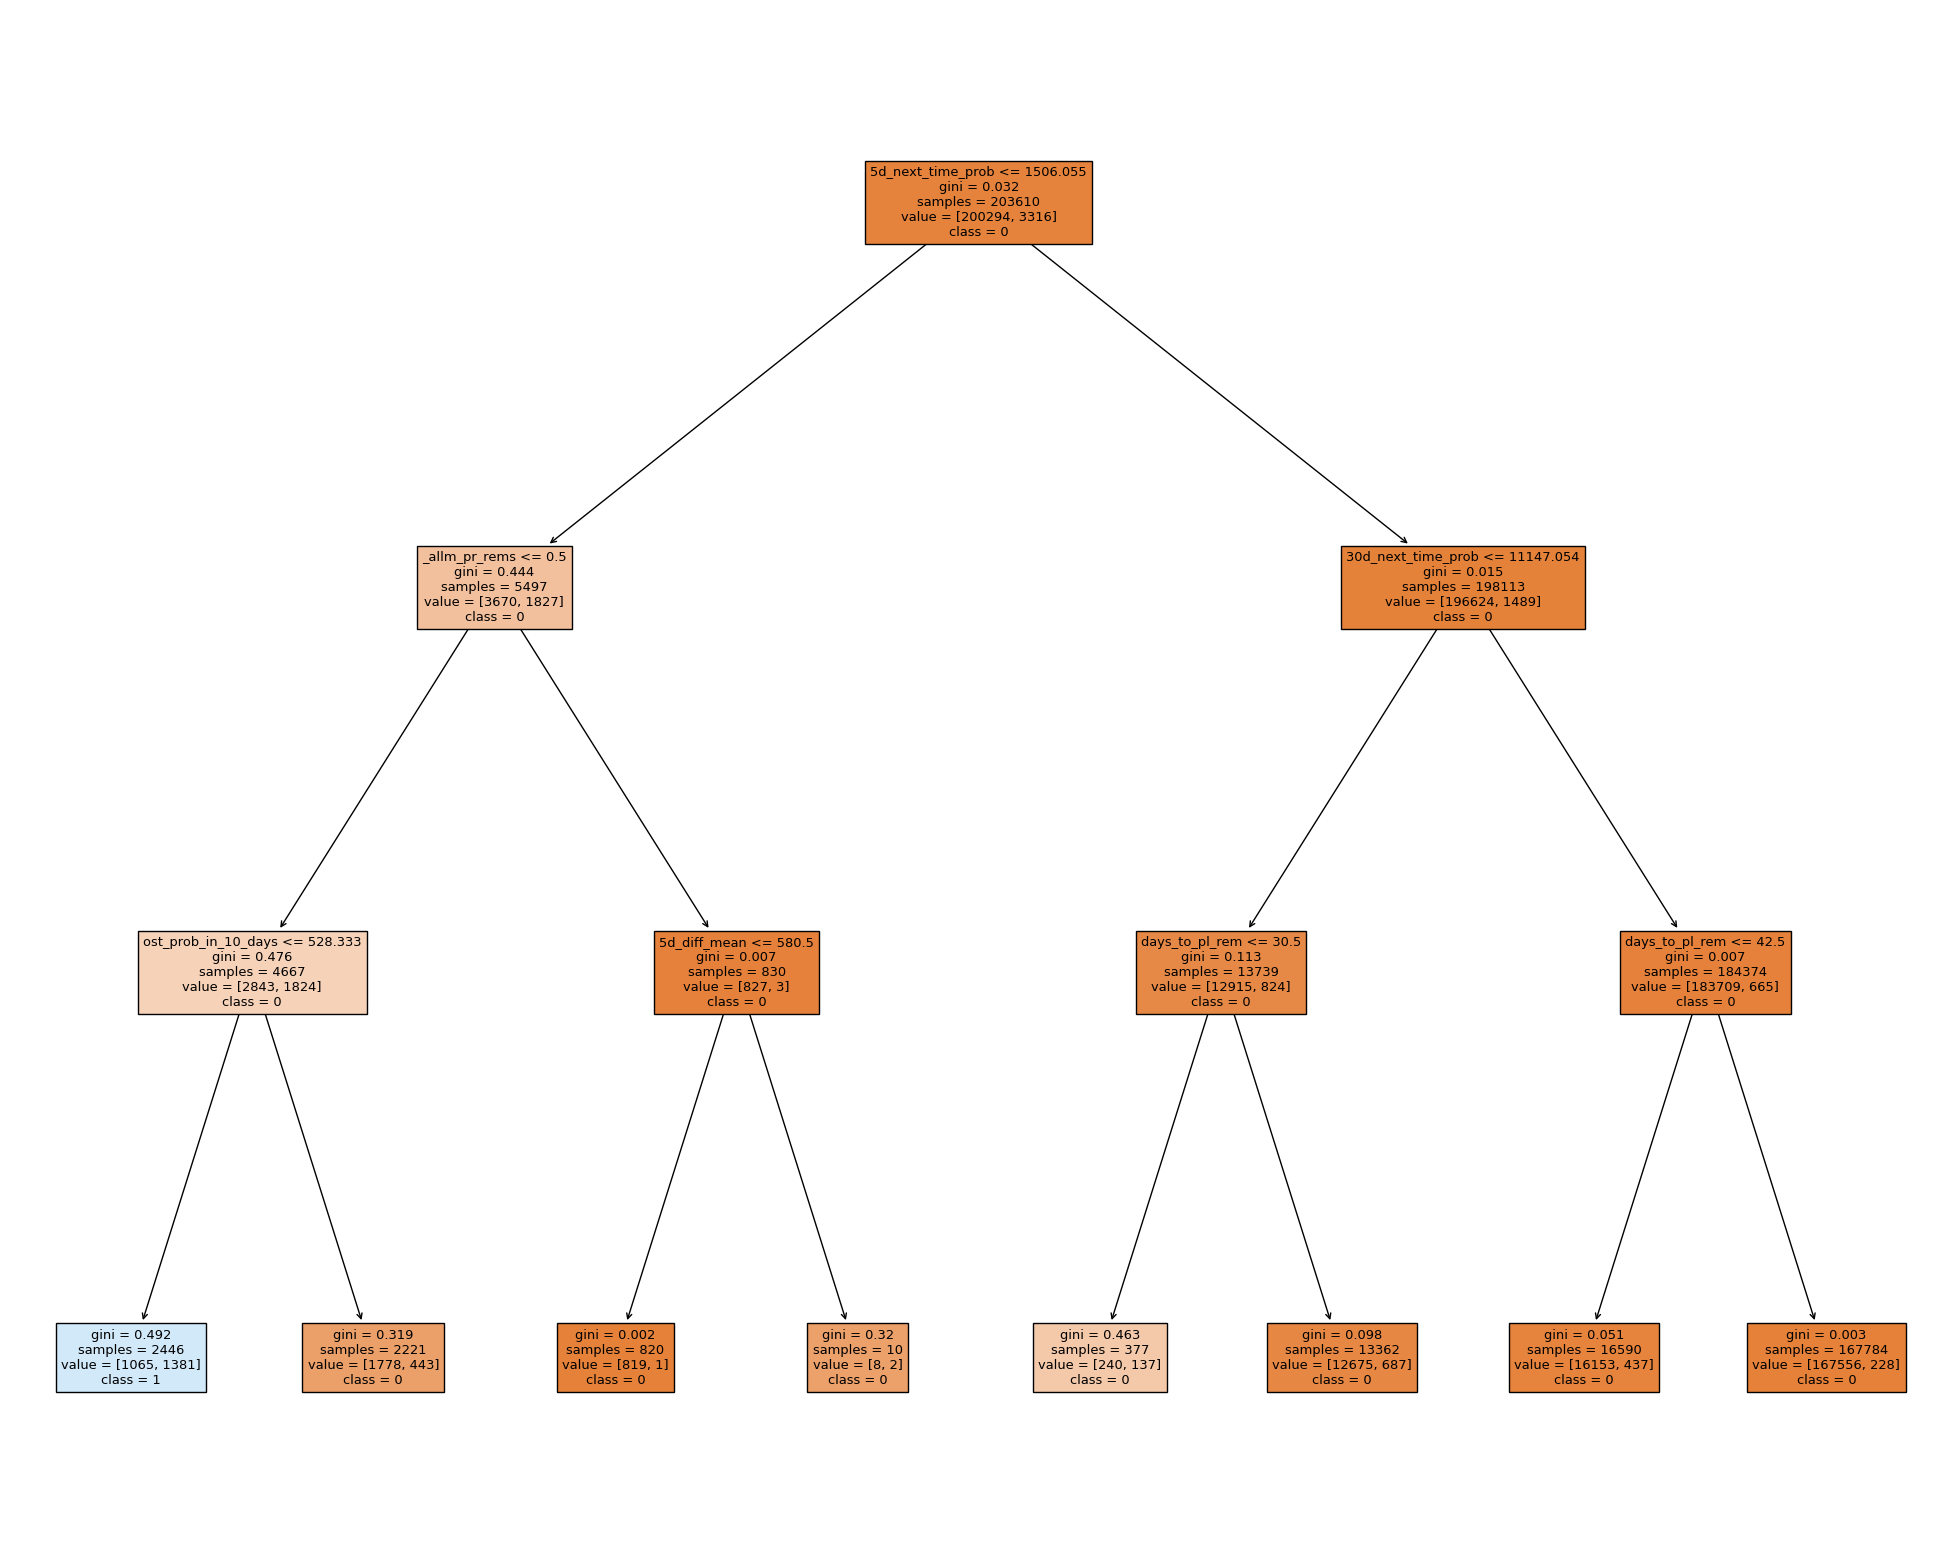

In [45]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt

clf = DecisionTreeClassifier(max_depth=3)
clf.fit(df_train[features_day], df_train['target_day'])

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=features_day,  
                   class_names=['0', '1'],
                   filled=True)

test = df_train.loc[test_ind, features_day]
f1_score(df_train.loc[test_ind]['target_day'], clf.predict(test))